## Trading Strategy - CounterTrend 

### 一. 環境設定 & import package

1.1 輸入tejapi key

In [1]:
import os
os.environ['TEJAPI_KEY'] = "your key" 
os.environ['TEJAPI_BASE'] = "https://api.tej.com.tw"

1.2 import package

In [2]:
import pandas as pd
import numpy as np
import pytz
# from datetime import datetime
import matplotlib.pyplot as plt
# import matplotlib

import zipline
from zipline.data import bundles
from zipline.utils.calendar_utils import get_calendar

from zipline.api import  *
from zipline.finance.commission import PerDollar,PerShare, PerTrade, PerContract
from zipline.finance.slippage import VolumeShareSlippage, FixedSlippage, VolatilityVolumeShare

from zipline.sources.TEJ_Api_Data import (get_Treasury_Return,
                                          get_Benchmark_Return)

from zipline.utils.run_algo import  (get_transaction_detail,
                                     get_record_vars)
import pyfolio as pf

plt.rcParams['axes.unicode_minus'] = False

### 二、樣本&期間

2.1 設定股票池與期間
- 股票池：輸入81檔權值股與加權股價報酬指數(IR0001)
- 期間：從2012-2022年

In [3]:
# set stocklist
StockList = \
['1101', '1102', '1216', '1301', '1303', '1326', '1402', '1722', '2002', '2105', '2201', '2207', '2301',
 '2303', '2308', '2311', '2317', '2324', '2325', '2330', '2347', '2353', '2354', '2357', '2382', '2409',
 '2412', '2454', '2474', '2498', '2801', '2880', '2881', '2882', '2883', '2885', '2886', '2890', '2891',
 '2892', '2912', '3008', '3045', '3231', '3481', '3673', '3697', '4904', '5880', '6505', '2884', '4938',
 '2887', '2227', '9904', '3474', '2395', '2408', '1476', '2823', '2633', '5871', '2327', '3711', '2492',
 '5876', '9910', '2888', '6669', '2379', '6415', '3034', '1590', '8046', '2603', '2609', '2615', '8454',
 '3037', '6770', '1605', 'IR0001']

# set backtest period
start='2012-01-01'
end='2023-07-30'

start_dt, end_dt = pd.Timestamp(start, tz = pytz.utc), pd.Timestamp(end, tz = pytz.utc)

2.2 樣本與期間設定輸入，並利用tejapi將開高低收量、調整股價資料綁入zipline
- 綁入名稱為`tquant的資料庫`，並指定交易日為`台股交易日誌:TEJ_XTAI`

In [4]:
os.environ['ticker'] = ' '.join(StockList)
os.environ['mdate'] = start+' '+end

In [5]:
!zipline ingest -b tquant

Merging daily equity files:


[2024-01-22 05:06:23.241824] INFO: zipline.data.bundles.core: Ingesting tquant.
[2024-01-22 05:06:46.124573] INFO: zipline.data.bundles.core: Ingest tquant successfully.


In [6]:
# calendar
calendar_name='TEJ_XTAI'  
# bundle_name
bundle_name = 'tquant'

### 三、建構交易策略
交易策略包含：進出場規則設定、持股配置、交易頻率，以及交易費用設定
- **進出場規則**
    - 趨勢filter
        - 利用指標作為過濾器，判斷股票的趨勢方向。
        - 正向趨勢條件：短均線ema(40)>長均線ema(80)。        
    - 進場rule
        - Long Entry:
            - 當趨勢為正且股價跌破近20日最高點下方三倍標準差的價格後，買進股票。    
    - 出場rule
        - Long Exit:
            - 當趨勢方向轉空，短均線ema(40)<長均線ema(80)，賣出股票。
            - 買進股票後持有超過20天。
    
- **持股配置**
    - 旨要利用配置與調整持股權重，使每檔股票對策略每日風險的貢獻程度大致均等。
    - 由於不同股票其價格波動的幅度差異很大，若以等權重配置會使策略的風險高度偏斜於波動大個股票。
    - 本範例會利用近期股價波動的標準差來衡量風險，作為調整持股配置的依據。
    
- **交易頻率**
    - 交易頻率設定為日頻。每日確認交易訊號，決定買賣股票與調整持股部位。    - 
    
- **交易費用**
    - 設定單次買賣股票金額的0.29%為佣金費用
    - 設定0%為滑價成本 
   


3.1 交易策略參數設定

In [7]:
# These lines are for the dynamic text reporting
from IPython.display import display
import ipywidgets as widgets
out = widgets.HTML()
display(out)

"""
Model Settings
"""
starting_portfolio = 10e6
risk_factor = 0.0015
slow_ma = 80
fast_ma = 40
vola_window = 60
high_window = 20
days_to_hold = 20
dip_buy = -3

'''
cost params setting
'''
commission_pct = 0.0029
slippage_volume_limit = 1.0
slippage_impact = 0

"""
Prepare for dynamic chart
"""
# dynamic_results = pd.DataFrame()
# fig = plt.figure(figsize=(10, 6))
# ax = fig.add_subplot(111)
# ax.set_title('Time Return Performance')

HTML(value='')

'\nPrepare for dynamic chart\n'

3.2 交易策略初始化設定

In [8]:
def initialize(context):

    # trading cost setting-----------------------------------------------------------------------------
    set_commission(PerDollar(cost=commission_pct))
    set_slippage(VolumeShareSlippage(volume_limit=slippage_volume_limit, price_impact=slippage_impact)) 
     
    # Make a list of all continuations-----------------------------------------------------------------
    bundle_data = bundles.load('tquant')
    context.universe = bundle_data.asset_finder.retrieve_all(bundle_data.asset_finder.equities_sids)#.remove(symbol('IR0001'))   
    
    # setting benchmark
    set_benchmark(symbol('IR0001'))     
     
    # We'll just use this for the progress output
    # during the backtest. Doesn't impact anything.
    context.months = 0    

    # Dictionary used for keeping track of how many days a position has been open.
    context.bars_held = {asset.symbol: 0 for asset in context.universe} 
    
    # Schedule daily trading
    schedule_function(daily_trade, date_rules.every_day(), time_rules.market_close())

    # Schedule monthly report output
    schedule_function(func=report_result,
                    date_rule=date_rules.month_start(),
                    time_rule=time_rules.market_open()
    )  

def report_result(context, data):
    context.months += 1
    today = zipline.api.get_datetime().date()
    # Calculate annualized return so far
    ann_ret = np.power(context.portfolio.portfolio_value / starting_portfolio, 
                   12 / context.months) - 1
    
    # Update the text
    out.value = """{} We have traded <b>{}</b> months  and the annualized return is <b>{:.2%}</b>""".format(today, context.months, ann_ret)


3.3 持股配置與進出場規則設定

In [9]:
def position_size(portfolio_value, std, point_value=1):
    risk_factor = 0.01
    target_variation = portfolio_value * risk_factor
    contract_variation = std * point_value
    contracts = target_variation / contract_variation
    return int(np.nan_to_num(contracts)) 

def daily_trade(context, data):    
    
    today = data.current_session.date()  
    todays_universe = context.universe
    
    hist_close = data.history(todays_universe, ['close','volume'], bar_count=high_window  + 1, frequency='1d')['close']
    hist_volume = data.history(todays_universe, ['close','volume'], bar_count=high_window  + 1, frequency='1d')['volume']    
        
    for _asset in todays_universe:
        
        h_close = hist_close.unstack()[_asset]
        h_volume = hist_volume.unstack()[_asset]
        h_std = hist_close.unstack().pct_change().iloc[-vola_window:].std()[_asset]*100 
        
        # Calculate the trend
        h_trend = h_close.ewm(span=fast_ma).mean() > h_close.ewm(span=slow_ma).mean() 
                
        if _asset in context.portfolio.positions:
            
            p = context.portfolio.positions[_asset]            
            context.bars_held[_asset] += 1 # One more day held
            
            if p.amount > 0: # Position is long
                if context.bars_held[_asset] >= 20:
                    # Held for a month, exit
                    order_target(_asset, 0)

                elif h_trend.iloc[-1] == False:
                    # Trend changed, exit.   
                    order_target(_asset, 0)   
                   
        else: # No position on
            if _asset==symbol('IR0001'): continue
            
            volume_to_trade = position_size(context.portfolio.portfolio_value, h_std,1)                   
                
            if h_trend.iloc[-1]:
                
                # Calculate the pullback
                pullback = (
                    h_close.values[-1] - np.max(h_close.values[-high_window:])) / h_std
                
                if pullback < dip_buy:
               
                    # Trade
                    volume_to_trade = position_size(context.portfolio.portfolio_value, h_std,1)  
                    order_value(_asset,volume_to_trade)
                    
                    # Reset bar count to zero
                    context.bars_held[_asset] = 0        
                
                

3.4 取得Treasury資料，以第一銀行(5844)一年期定存利率作為無風險利率。

In [10]:
start = pd.Timestamp('2022-01-01', tz='utc'), 
end   = pd.Timestamp('2022-12-30', tz='utc'), 

treasury_returns = get_Treasury_Return(start = start_dt,
                                      end = end_dt,
                                      rate_type = 'Time_Deposit_Rate',                     
                                      term = '1y',
                                      symbol = '5844')
treasury_returns

mdate
2012-01-02 00:00:00+00:00    0.000053
2012-01-03 00:00:00+00:00    0.000053
2012-01-04 00:00:00+00:00    0.000053
2012-01-05 00:00:00+00:00    0.000053
2012-01-06 00:00:00+00:00    0.000053
                               ...   
2023-07-24 00:00:00+00:00    0.000062
2023-07-25 00:00:00+00:00    0.000062
2023-07-26 00:00:00+00:00    0.000062
2023-07-27 00:00:00+00:00    0.000062
2023-07-28 00:00:00+00:00    0.000062
Length: 2835, dtype: float64

3.5 執行回測

In [11]:
results = zipline.run_algorithm(
                start = pd.Timestamp('2018-06-01', tz='utc'), 
                end   = pd.Timestamp('2023-07-30', tz='utc'), 
                initialize=initialize,                 
                capital_base=starting_portfolio,  
                data_frequency = 'daily', 
                treasury_returns=treasury_returns,
                trading_calendar=get_calendar(calendar_name),
                bundle=bundle_name)

### 4.策略績效分析
4.1 利用pyfolio分析評估策略的風險與報酬表現

Start date,2018-06-01
End date,2023-07-28
Total months,59
,Backtest
Annual return,0.338%
Cumulative returns,1.703%
Annual volatility,1.086%
Sharpe ratio,0.32
Calmar ratio,0.09
Stability,0.24
Max drawdown,-3.652%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,3.65,2021-05-10,2022-11-03,NaT,NaN
1,1.12,2018-06-06,2018-12-26,2019-04-09,205
2,0.77,2019-04-25,2019-08-06,2019-10-08,114
3,0.66,2020-08-06,2020-11-02,2020-12-31,103
4,0.46,2020-01-20,2020-02-05,2020-04-29,63


Stress Events,mean,min,max
New Normal,0.00%,-0.46%,0.28%


Top 10 long positions of all time,max
sid,
3045,2.61%
2412,2.54%
2227,2.26%
1326,2.24%
1303,1.99%
2912,1.97%
2357,1.91%
8454,1.87%
4904,1.81%


Top 10 short positions of all time,max
sid,
2327,-0.63%


Top 10 positions of all time,max
sid,
3045,2.61%
2412,2.54%
2227,2.26%
1326,2.24%
1303,1.99%
2912,1.97%
2357,1.91%
8454,1.87%
4904,1.81%


Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.


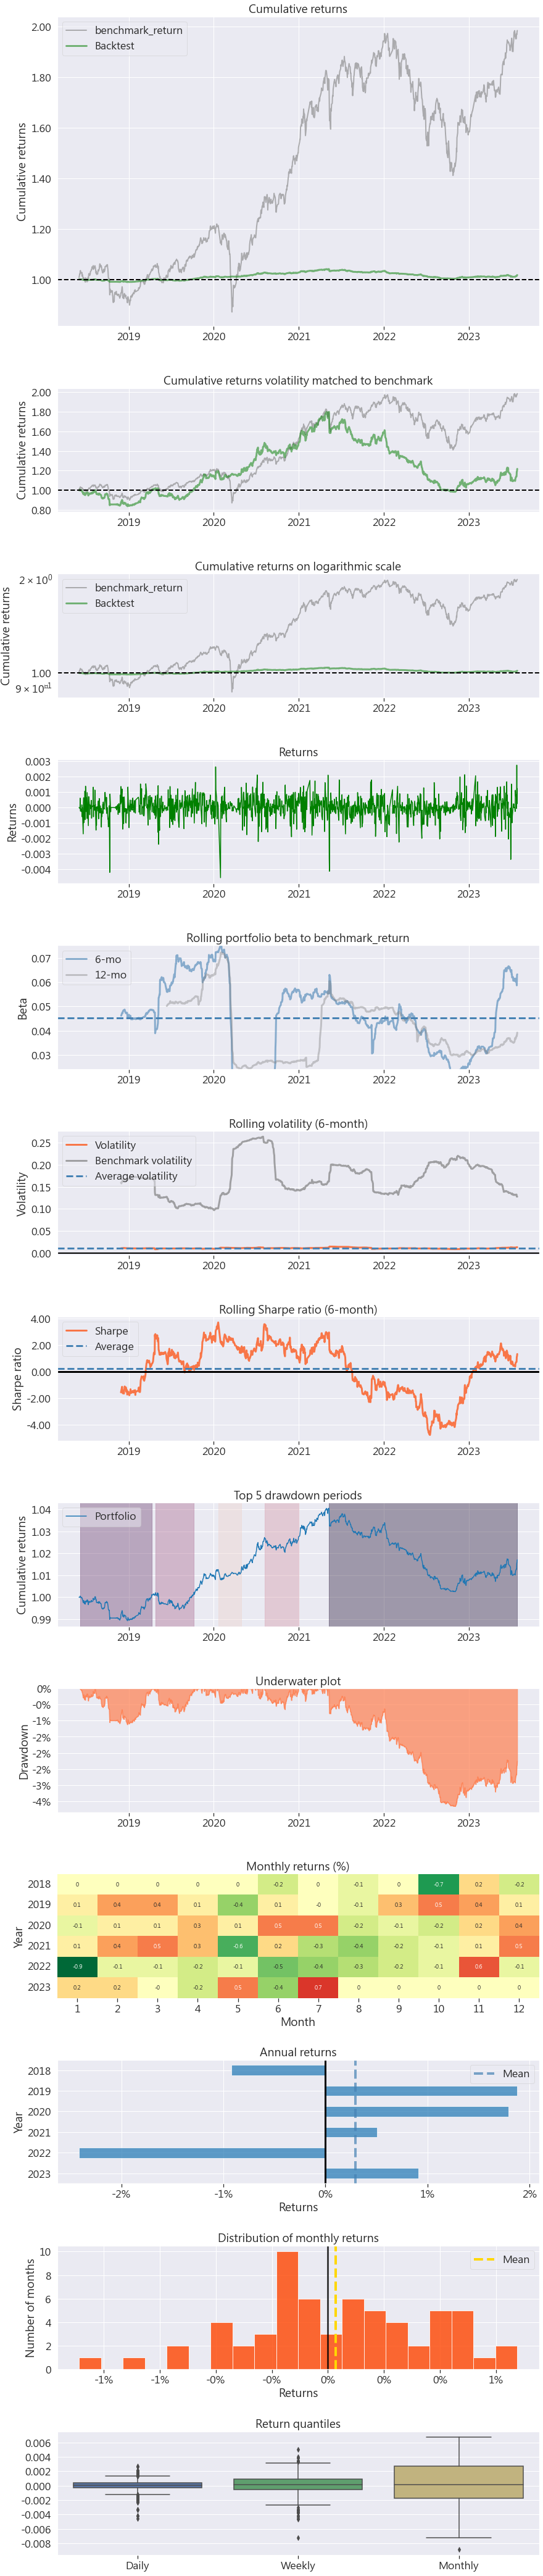

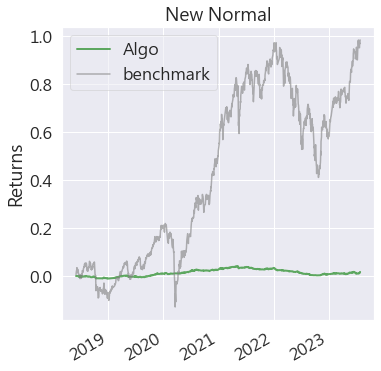

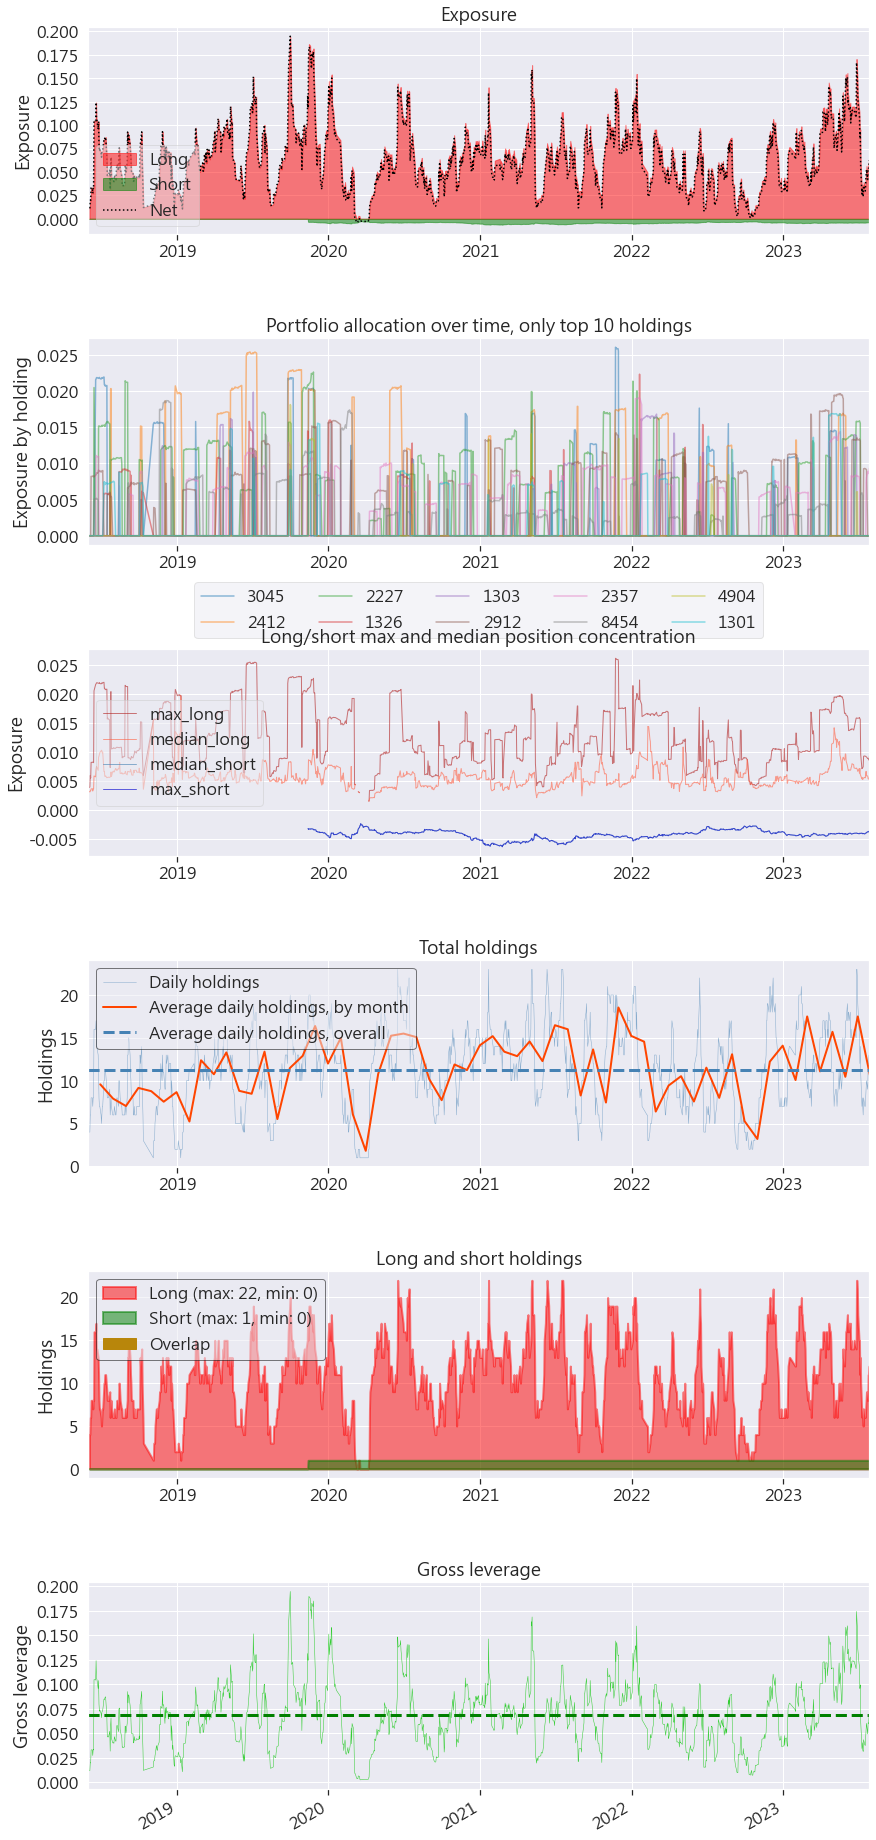

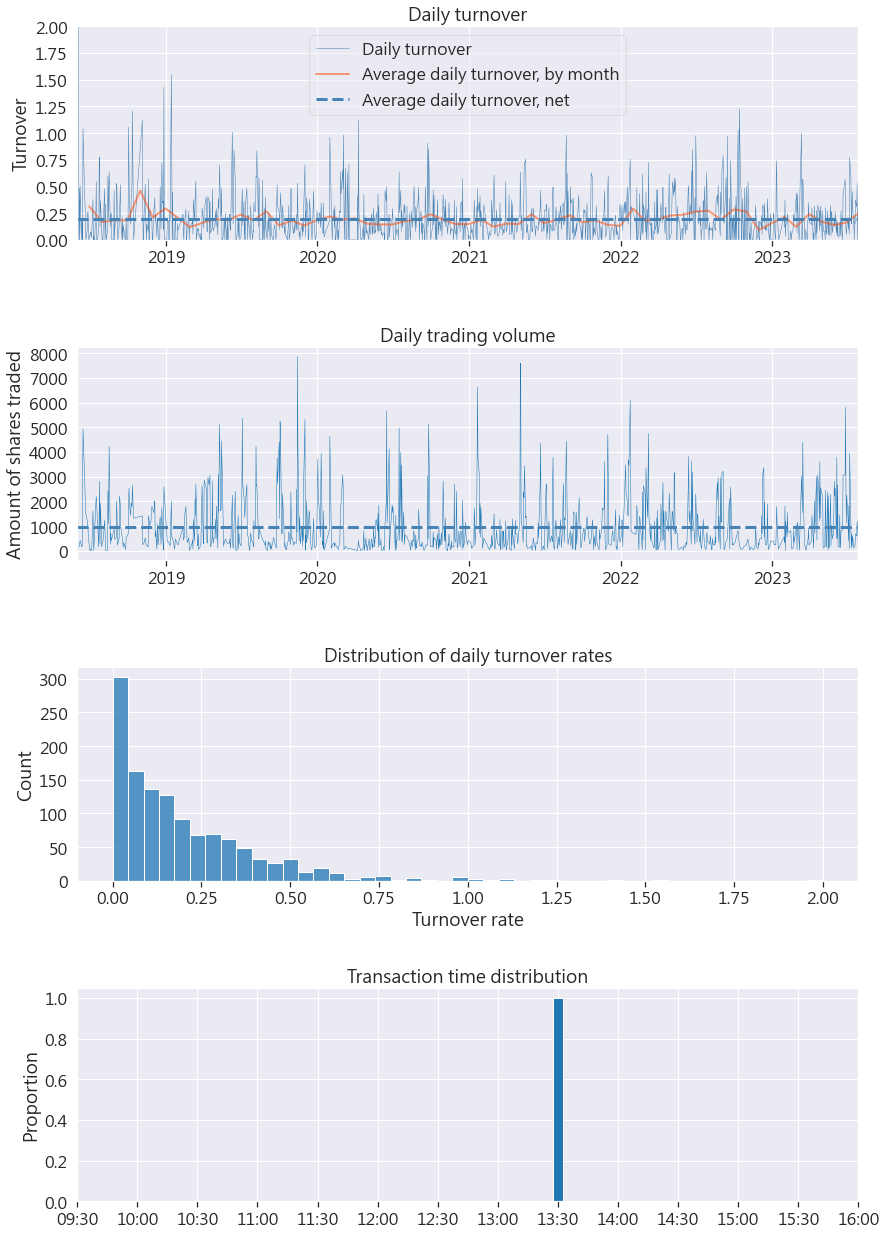

In [12]:
import pyfolio as pf
import empyrical

bt_returns, bt_positions, bt_transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)
benchmark_rets = results.benchmark_return

bt_returns.index = bt_returns.index.tz_localize(None).tz_localize('UTC')
bt_positions.index = bt_positions.index.tz_localize(None).tz_localize('UTC')
bt_transactions.index = bt_transactions.index.tz_localize(None).tz_localize('UTC')
benchmark_rets.index = benchmark_rets.index.tz_localize(None).tz_localize('UTC')


# Creating a Full Tear Sheet
pf.create_full_tear_sheet(bt_returns, positions=bt_positions, transactions=bt_transactions,
                          benchmark_rets=benchmark_rets,
                          #live_start_date='2022-01-01', 
                          round_trips=False)

4.2 整理交易細節：positions／transactions／orders資訊


In [13]:
positions, transactions, orders = get_transaction_detail(results)
positions

,sid,symbol,asset,amount,cost_basis,last_sale_price
2018-06-04 00:00:00+00:00,8,1590,Equity(8 [1590]),60,542.5689,541.0
2018-06-04 00:00:00+00:00,23,2327,Equity(23 [2327]),14,1073.1030,1070.0
2018-06-04 00:00:00+00:00,58,3008,Equity(58 [3008]),7,4427.8035,4415.0
2018-06-04 00:00:00+00:00,73,6415,Equity(73 [6415]),58,676.9575,675.0
2018-06-05 00:00:00+00:00,8,1590,Equity(8 [1590]),60,542.5689,524.0
...,...,...,...,...,...,...
2023-07-28 00:00:00+00:00,37,2492,Equity(37 [2492]),624,95.2755,95.7
2023-07-28 00:00:00+00:00,59,3034,Equity(59 [3034]),126,409.1832,416.5
2023-07-28 00:00:00+00:00,31,2395,Equity(31 [2395]),140,396.1455,402.0
2023-07-28 00:00:00+00:00,36,2474,Equity(36 [2474]),405,178.5162,175.0


In [14]:
transactions

,sid,symbol,amount,dt,price,order_id,asset,commission
2018-06-04 00:00:00+00:00,8,1590,60,2018-06-04 13:30:00+08:00,541.0,7ac33592733a41149b1ec94a1d46679c,Equity(8 [1590]),None
2018-06-04 00:00:00+00:00,23,2327,14,2018-06-04 13:30:00+08:00,1070.0,f76f883334c9475bb5a291ddd1b010fe,Equity(23 [2327]),None
2018-06-04 00:00:00+00:00,58,3008,7,2018-06-04 13:30:00+08:00,4415.0,5465c48b6f4b47168dd63472a61c4ea4,Equity(58 [3008]),None
2018-06-04 00:00:00+00:00,73,6415,58,2018-06-04 13:30:00+08:00,675.0,b772aac697f140ac834770ae700fc38d,Equity(73 [6415]),None
2018-06-06 00:00:00+00:00,7,1476,153,2018-06-06 13:30:00+08:00,389.5,e6bb483a64ab481d96d75328683f8792,Equity(7 [1476]),None
...,...,...,...,...,...,...,...,...
2023-07-27 00:00:00+00:00,31,2395,140,2023-07-27 13:30:00+08:00,395.0,603e44992881498aab388595ceea2d4d,Equity(31 [2395]),None
2023-07-27 00:00:00+00:00,36,2474,405,2023-07-27 13:30:00+08:00,178.0,a9b0ed25230a4331884211d819fd84ec,Equity(36 [2474]),None
2023-07-27 00:00:00+00:00,58,3008,-27,2023-07-27 13:30:00+08:00,2165.0,d05d447757cd47dbb67000e5abe9b695,Equity(58 [3008]),None
2023-07-28 00:00:00+00:00,7,1476,111,2023-07-28 13:30:00+08:00,547.0,7e183338a61a4b3eb1d61e055a976834,Equity(7 [1476]),None


In [15]:
orders

,sid,symbol,id,dt,reason,created,amount,filled,commission,stop,limit,stop_reached,limit_reached,asset,status
2018-06-01 00:00:00+00:00,8,1590,7ac33592733a41149b1ec94a1d46679c,2018-06-01 13:30:00+08:00,None,2018-06-01 13:30:00+08:00,60,0,0.00000,None,None,False,False,Equity(8 [1590]),0
2018-06-01 00:00:00+00:00,23,2327,f76f883334c9475bb5a291ddd1b010fe,2018-06-01 13:30:00+08:00,None,2018-06-01 13:30:00+08:00,14,0,0.00000,None,None,False,False,Equity(23 [2327]),0
2018-06-01 00:00:00+00:00,58,3008,5465c48b6f4b47168dd63472a61c4ea4,2018-06-01 13:30:00+08:00,None,2018-06-01 13:30:00+08:00,7,0,0.00000,None,None,False,False,Equity(58 [3008]),0
2018-06-01 00:00:00+00:00,73,6415,b772aac697f140ac834770ae700fc38d,2018-06-01 13:30:00+08:00,None,2018-06-01 13:30:00+08:00,58,0,0.00000,None,None,False,False,Equity(73 [6415]),0
2018-06-04 00:00:00+00:00,8,1590,7ac33592733a41149b1ec94a1d46679c,2018-06-04 13:30:00+08:00,None,2018-06-01 13:30:00+08:00,60,60,94.13400,None,None,False,False,Equity(8 [1590]),1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-27 00:00:00+00:00,77,8046,eafe13f10ac24add814c348c6932b741,2023-07-27 13:30:00+08:00,None,2023-07-27 13:30:00+08:00,-153,0,0.00000,None,None,False,False,Equity(77 [8046]),0
2023-07-28 00:00:00+00:00,7,1476,7e183338a61a4b3eb1d61e055a976834,2023-07-28 13:30:00+08:00,None,2023-07-27 13:30:00+08:00,111,111,176.07930,None,None,False,False,Equity(7 [1476]),1
2023-07-28 00:00:00+00:00,77,8046,eafe13f10ac24add814c348c6932b741,2023-07-28 13:30:00+08:00,None,2023-07-27 13:30:00+08:00,-153,-153,112.92165,None,None,False,False,Equity(77 [8046]),1
2023-07-28 00:00:00+00:00,39,2603,1bb10f43057f4a3dbc81068fa6f82f08,2023-07-28 13:30:00+08:00,None,2023-07-28 13:30:00+08:00,-275,0,0.00000,None,None,False,False,Equity(39 [2603]),0
